In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

# read data

In [2]:
nodes_addresses = pd.read_csv("./data/nodes-addresses.csv", low_memory=False, index_col=0)
nodes_addresses["node_type"] = ["Address"]*len(nodes_addresses)

nodes_entities = pd.read_csv("./data/nodes-entities.csv", low_memory=False, index_col=0)
nodes_entities["node_type"] = ["Entity"]*len(nodes_entities)

nodes_intermediaries = pd.read_csv("./data/nodes-intermediaries.csv", low_memory=False, index_col=0)
nodes_intermediaries["node_type"] = ["Intermediary"]*len(nodes_intermediaries)

nodes_officers = pd.read_csv("./data/nodes-officers.csv", low_memory=False, index_col=0)
nodes_officers["node_type"] = ["Officer"]*len(nodes_officers)

nodes_others = pd.read_csv("./data/nodes-others.csv", low_memory=False, index_col=0)
nodes_others["node_type"] = ["Other"]*len(nodes_others)

relationships = pd.read_csv("./data/relationships.csv", low_memory=False).set_index(["node_id_start", "node_id_end"])

G = nx.MultiDiGraph() #directed multi-edge graph
G.add_nodes_from([(key, value) for key, value in nodes_addresses.to_dict("index").items()])
G.add_nodes_from([(key, value) for key, value in nodes_entities.to_dict("index").items()])
G.add_nodes_from([(key, value) for key, value in nodes_intermediaries.to_dict("index").items()])
G.add_nodes_from([(key, value) for key, value in nodes_officers.to_dict("index").items()])
G.add_nodes_from([(key, value) for key, value in nodes_others.to_dict("index").items()])
G.add_edges_from([(*relationships.index[i], value) for i, value in enumerate(relationships.to_dict(orient='records'))])

del nodes_addresses
del nodes_entities
del nodes_intermediaries
del nodes_officers
del nodes_others
del relationships

In [3]:
G.size()

3339267

# simplified network

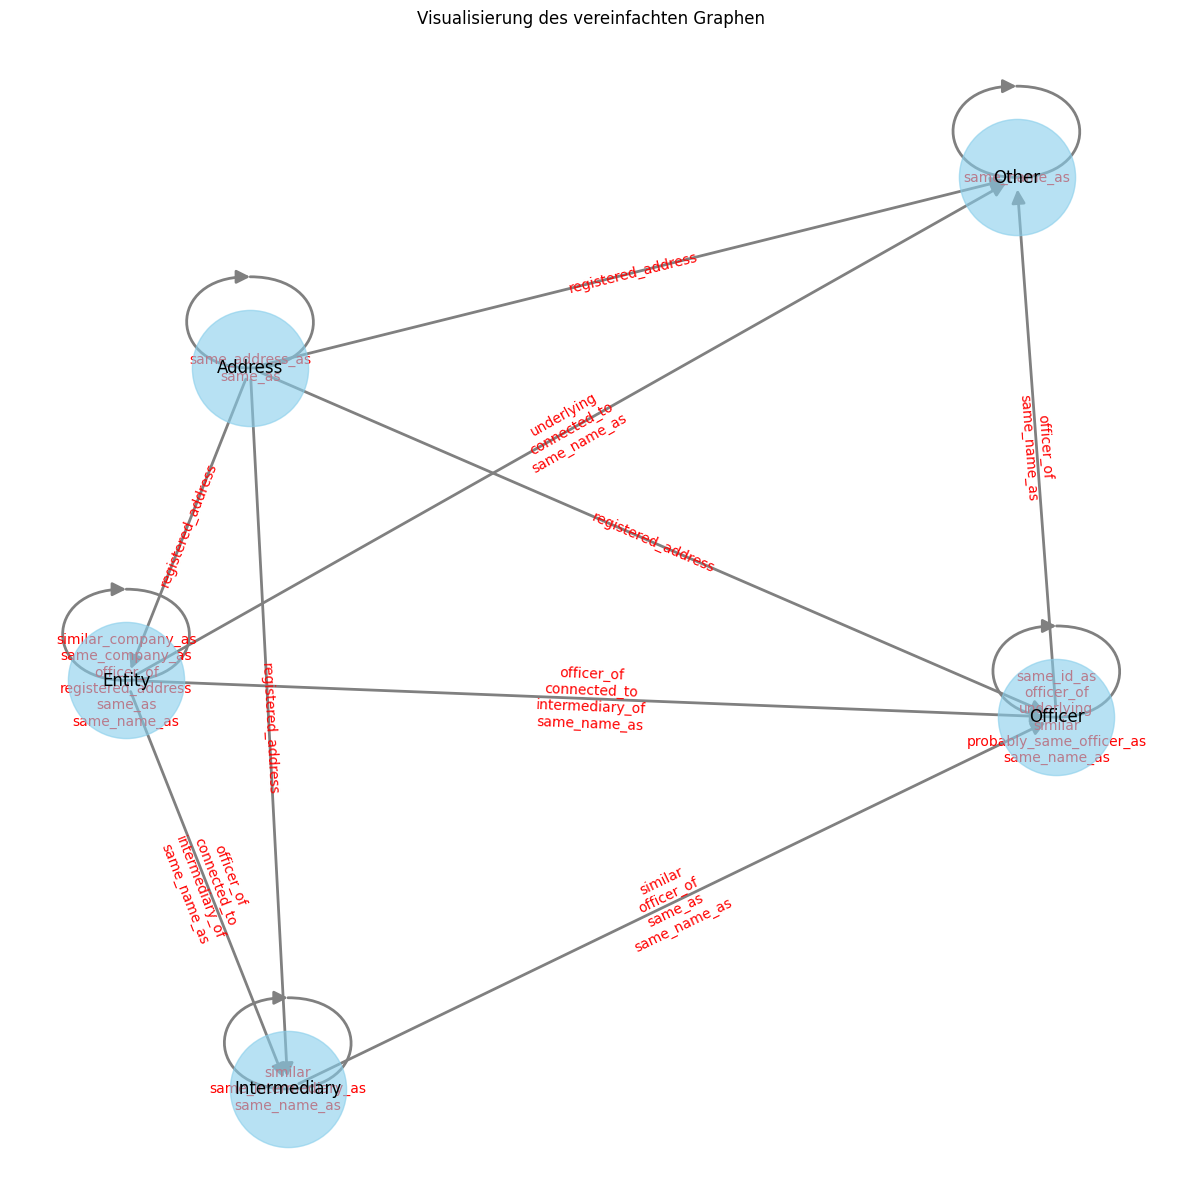

In [4]:
def simplify_graph(graph):
    """
    Vereinfacht einen Graphen, indem Knoten auf Basis des 'node_type' zusammengefasst werden.
    Kanten werden basierend auf dem 'rel_type' zwischen den Knotentypen vereinfacht.
    
    Parameters:
        graph (nx.Graph): Der ursprüngliche Graph mit komplexen Verbindungen und Knotenattributen.
    
    Returns:
        nx.Graph: Ein vereinfachter Graph, der nur Knotentypen und die Verbindungstypen zwischen ihnen zeigt.
    """
    simplified_graph = nx.Graph()

    # Mapping von node_type zu einem eindeutigen Knoten im vereinfachten Graphen
    node_type_map = {}

    # Knoten nach Typ gruppieren
    for node, attr in graph.nodes(data=True):
        node_type = attr.get('node_type', None)
        if node_type not in node_type_map:
            node_type_map[node_type] = node_type
            simplified_graph.add_node(node_type, node_type=node_type)
    
    # Kanten nach Verbindungstyp gruppieren
    for u, v, attributes in graph.edges(data=True):
        u_type = graph.nodes[u].get('node_type', None)
        v_type = graph.nodes[v].get('node_type', None)
        rel_type = attributes.get('rel_type', None)
        
        # Prüfen, ob eine Kante zwischen den Typen bereits existiert
        if simplified_graph.has_edge(u_type, v_type):
            # Fügen den neuen Verbindungstyp hinzu, wenn er noch nicht vorhanden ist
            existing_types = simplified_graph[u_type][v_type]['rel_type']
            if rel_type not in existing_types:
                simplified_graph[u_type][v_type]['rel_type'].add(rel_type)
        else:
            # Erstellen der Kante mit einem Set, das den Verbindungstyp enthält
            simplified_graph.add_edge(u_type, v_type, rel_type={rel_type})
    
    return simplified_graph

def draw_graph(graph, figsize=(15, 15)):
    """
    Zeichnet den Graphen mit Knoten- und Kantenattributen, wobei die Kantenattribute untereinander angezeigt werden.

    Parameters:
        graph (nx.Graph): Der zu zeichnende Graph.
        figsize (tuple): Größe des Bildes in Zoll (Breite, Höhe).
    """
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(graph)  # Layout der Knoten im Graphen
    
    nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=7000, alpha=0.6)
    nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=2)
    
    node_labels = {node: f"{data['node_type']}" for node, data in graph.nodes(data=True)}
    nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=12)

    try:
        # Mehrere Kantenattribute untereinander plotten
        edge_labels = {(u, v): '\n'.join(data['rel_type']) for u, v, data in graph.edges(data=True)}
        
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='red', bbox={"alpha":0})
    except:
        pass
    
    plt.title('Visualisierung des vereinfachten Graphen')
    plt.axis('off')
    plt.show()
    
draw_graph(simplify_graph(G))

# Merge same nodes

## Intermediaries

In [5]:
def merge_same_intermediaries(G:nx.MultiDiGraph):
    G_ = G.copy()

    while True:
        edge_found = False #is true if no edge with rel_type of 'same_intermediary_as' or 'same_name_as' found
        for u, v, e_attr in list(G_.edges(data=True)): #iterate through edges
            if e_attr["rel_type"] in ["same_intermediary_as", "same_name_as"]: #if specifig edge found

                #try merge
                try:
                    u_ = G_.nodes[u]
                    v_ = G_.nodes[v]

                    #if Intermediary self loop
                    if u_["node_type"]  == "Intermediary" and v_["node_type"]  == "Intermediary":
                        edge_found = True

                        #take older valid_until node and merge
                        if int(u_["valid_until"].split(" ")[-1].replace(".", "")) > int(v_["valid_until"].split(" ")[-1].replace(".", "")):
                            nx.contracted_nodes(G_, v, u, self_loops=False, copy=False)

                        else:
                            nx.contracted_nodes(G_, u, v, self_loops=False, copy=False)

                except:
                    pass

        if not edge_found:
            break
        
    return G_

G = merge_same_intermediaries(G)

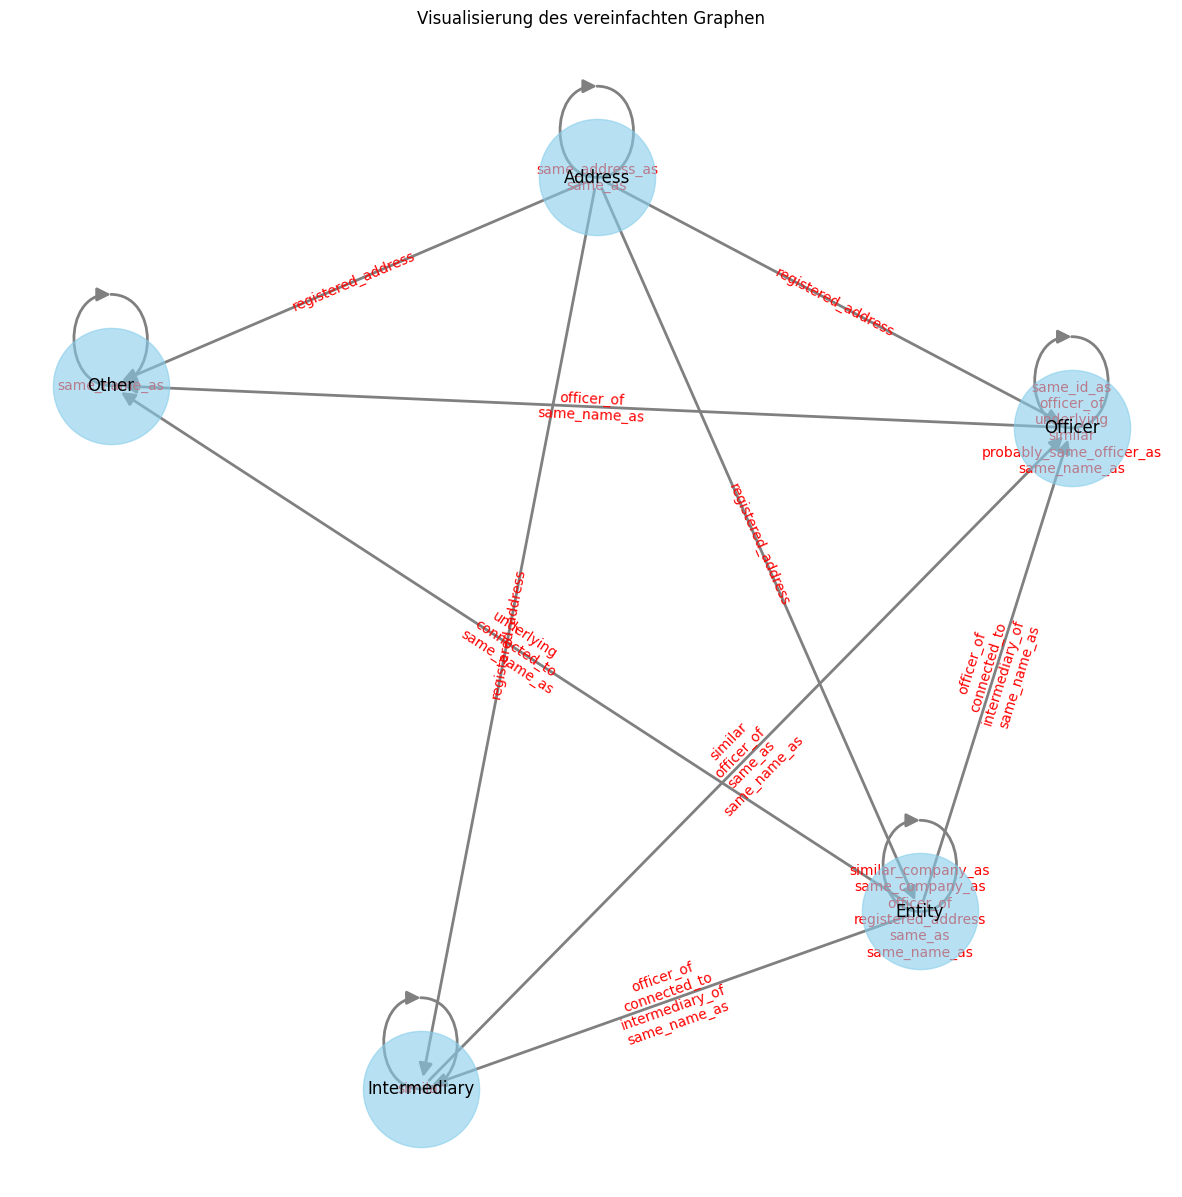

In [6]:
draw_graph(simplify_graph(G))

## Entity

In [7]:
def parse_valid_until(input:str):
    try:
        return int(input)

    except:
        
        if input is np.nan:
            return 0
        
        try:
            return int(input.split(" ")[-1].replace(".", ""))
            
        except:
            if input.split(" ")[-1].replace(".", "") == "nan":
                return 0        
            
def merge_same_entities(G:nx.MultiDiGraph):
    G_ = G.copy()

    while True:
        edge_found = False #is true if no edge with rel_type of 'same_company_as' or 'same_as' or 'same_name_as' found
        for u, v, e_attr in list(G_.edges(data=True)): #iterate through edges
            if e_attr["rel_type"] in ["same_company_as", "same_as", "same_name_as"]: #if specifig edge found

                #try merge
                try:
                    u_ = G_.nodes[u]
                    v_ = G_.nodes[v]

                    #if Entity self loop
                    if u_["node_type"] == "Entity" and v_["node_type"] == "Entity":
                        edge_found = True

                        if parse_valid_until(u_["valid_until"]) > parse_valid_until(v_["valid_until"]):
                            nx.contracted_nodes(G_, v, u, self_loops=False, copy=False)

                        else:
                            nx.contracted_nodes(G_, u, v, self_loops=False, copy=False)
                        
                except:
                    pass

        if not edge_found:
            break
        
    return G_

G = merge_same_entities(G)

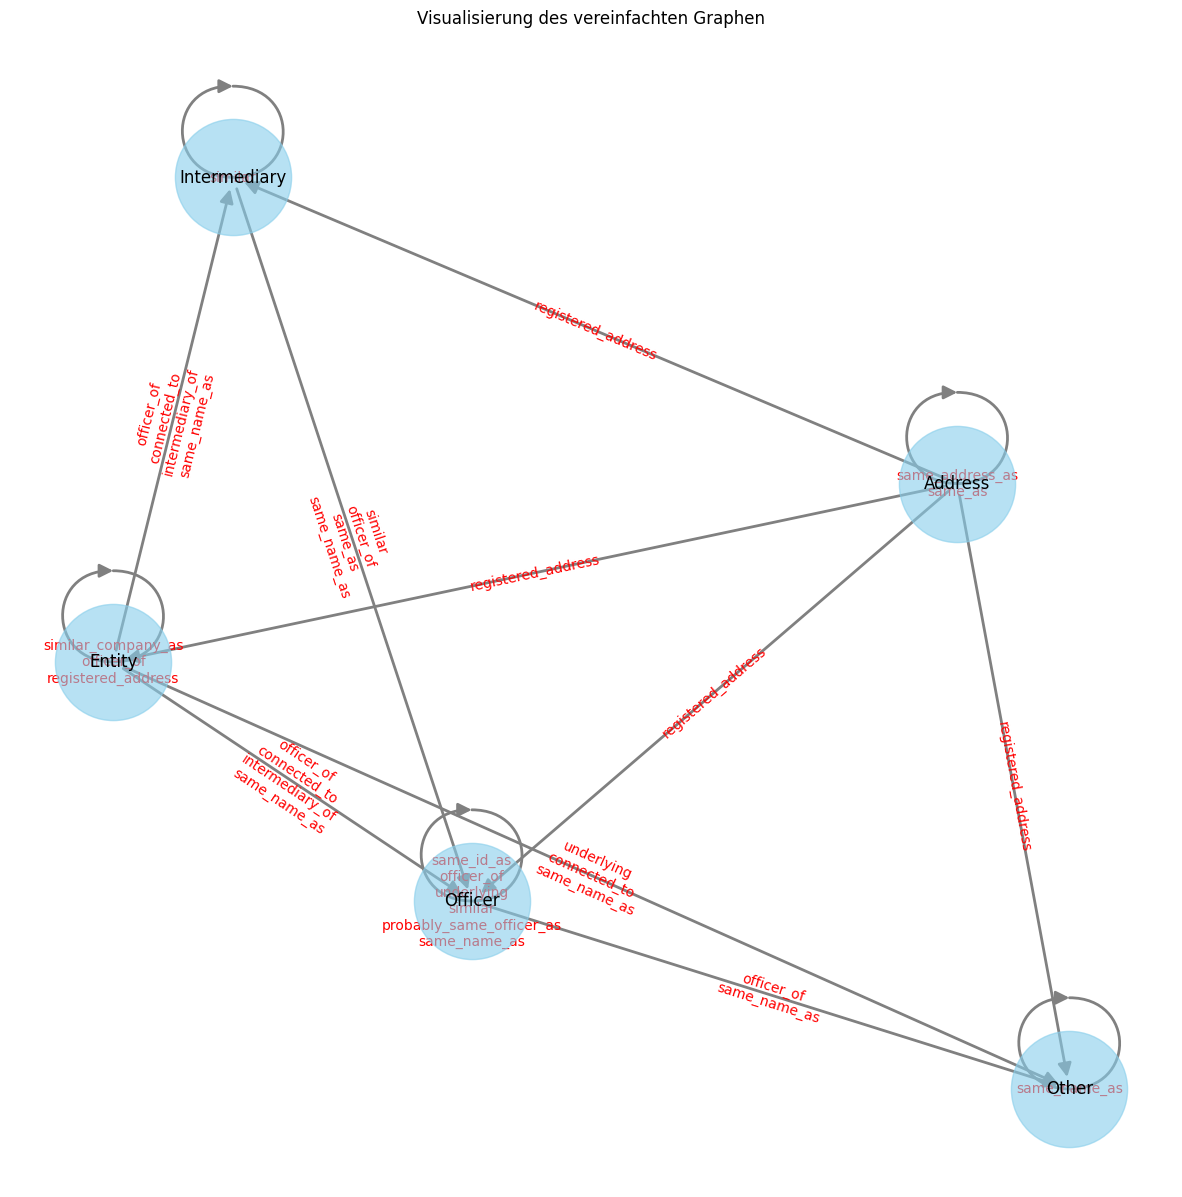

In [8]:
draw_graph(simplify_graph(G))

# Officers

In [9]:
def parse_valid_until(input:str):
    try:
        return int(input)

    except:
        
        if input is np.nan:
            return 0
        
        try:
            return int(input.split(" ")[-1].replace(".", ""))
            
        except:
            try:
                return int(input.split(".")[0].split(" ")[-1].replace(".", ""))

            except:
                if input.split(" ")[-1].replace(".", "") == "nan":
                    return 0        
           
def merge_same_officers(G:nx.MultiDiGraph):
    G_ = G.copy()

    while True:
        edge_found = False #is true if no edge with rel_type of 'same_id_as' or 'probably_same_officer_as' or 'same_name_as' found
        for u, v, e_attr in list(G_.edges(data=True)): #iterate through edges
            if e_attr["rel_type"] in ["same_id_as", "probably_same_officer_as", "same_name_as"]: #if specifig edge found

                #try merge
                try:
                    u_ = G_.nodes[u]
                    v_ = G_.nodes[v]

                    #if Officer self loop
                    if u_["node_type"]  == "Officer" and v_["node_type"]  == "Officer":
                        edge_found = True

                        if parse_valid_until(u_["valid_until"]) > parse_valid_until(v_["valid_until"]):
                            nx.contracted_nodes(G_, v, u, self_loops=False, copy=False)

                        else:
                            nx.contracted_nodes(G_, u, v, self_loops=False, copy=False)

                except:
                    pass

        if not edge_found:
            break
        
    return G_

G = merge_same_officers(G)

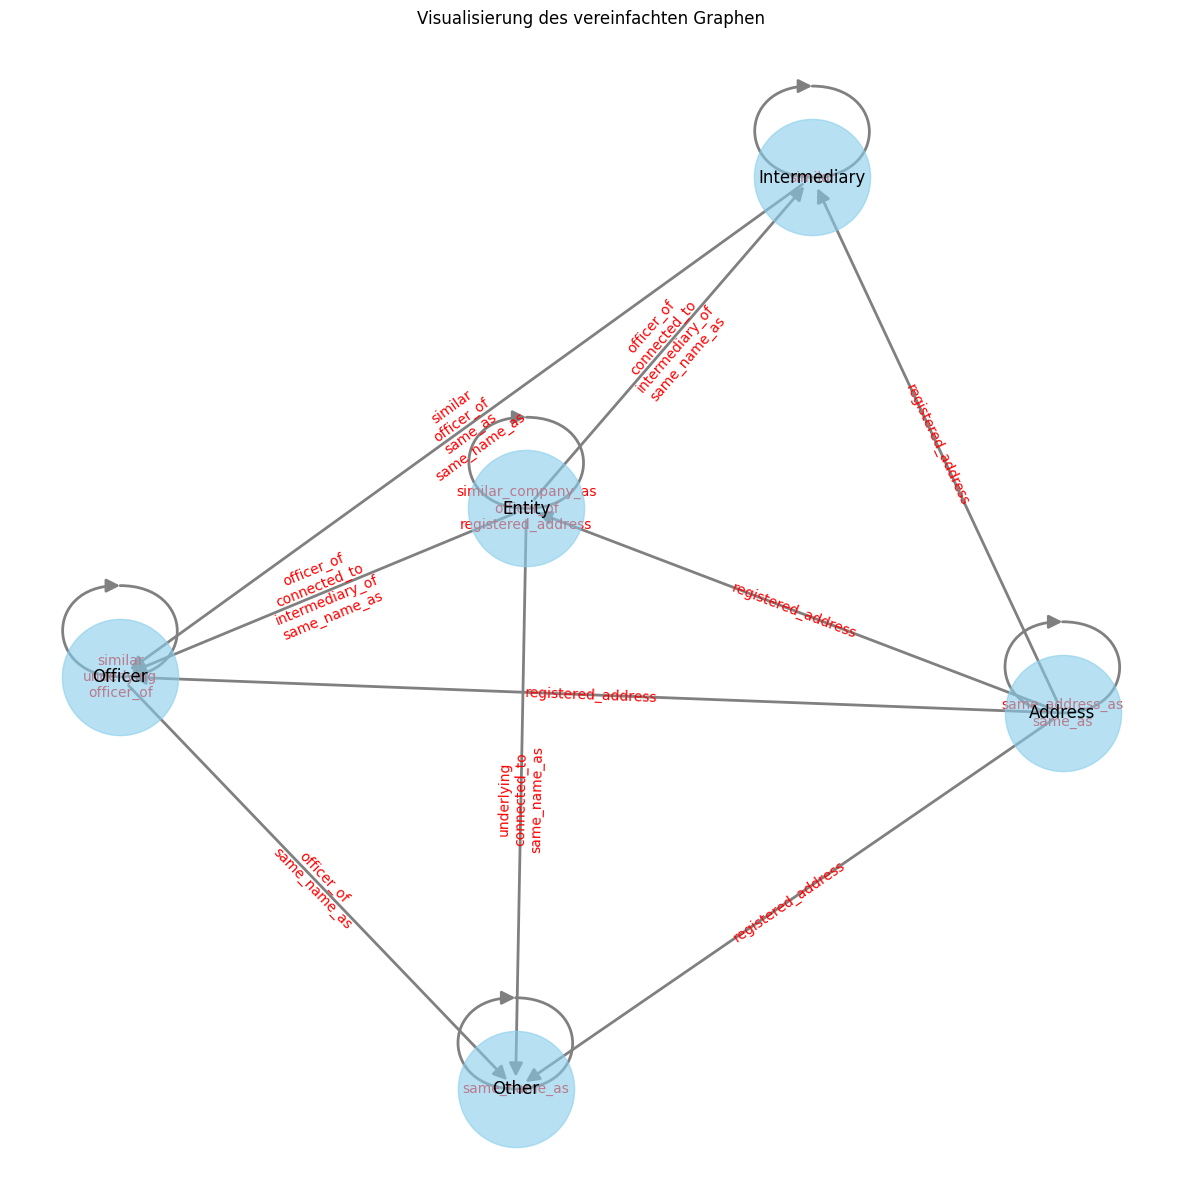

In [10]:
draw_graph(simplify_graph(G))

# Node distribution

<BarContainer object of 5 artists>

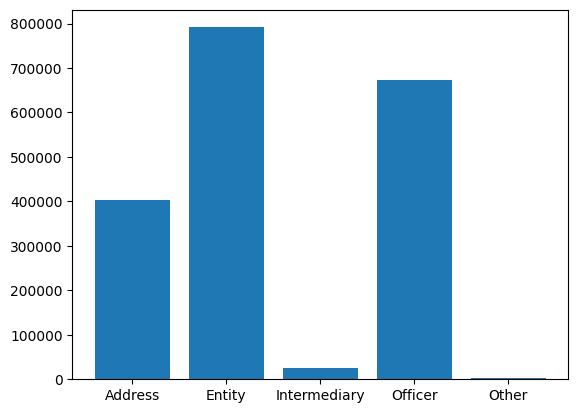

In [11]:
plt.bar(*np.unique(list(nx.get_node_attributes(G, 'node_type').values()), return_counts=True))

# Remove unneccessary Address node

In [12]:
entity_officers = G.subgraph([node for node, data in G.nodes(data=True) if data["node_type"] in ["Officer", "Entity"]])

In [13]:
entity_officers.size()

1768567

# remove self loops

In [14]:
no_self_loops = nx.Graph(nx.subgraph_view(entity_officers, filter_edge=lambda u,v,_: entity_officers.nodes[u]["node_type"] != entity_officers.nodes[v]["node_type"]))

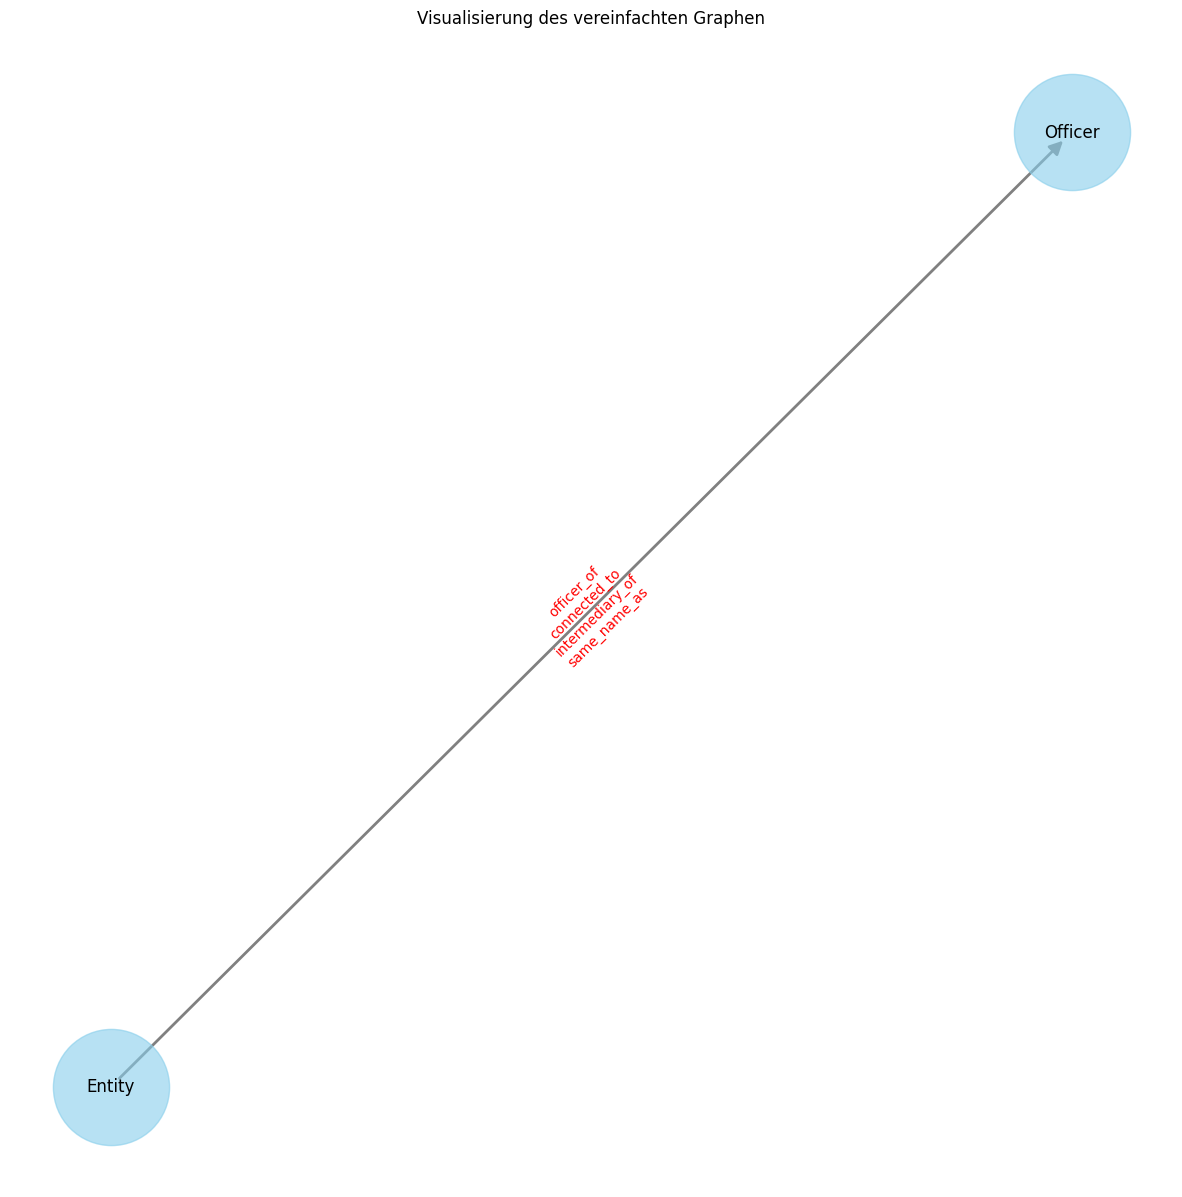

In [15]:
draw_graph(simplify_graph(no_self_loops))

# newmanns weighted projection

In [16]:
projection:nx.Graph = nx.bipartite.collaboration_weighted_projected_graph(
    no_self_loops,
    [u for u,attr in no_self_loops.nodes(data=True) if attr["node_type"]=="Officer"]
)

In [17]:
projection.number_of_nodes()

672778

# connected components

In [18]:
[len(c) for c in sorted(nx.connected_components(projection), key=len, reverse=True)]

[122255,
 81703,
 71075,
 49058,
 8443,
 1653,
 1570,
 1006,
 492,
 465,
 409,
 320,
 300,
 294,
 279,
 261,
 261,
 244,
 209,
 201,
 171,
 167,
 166,
 153,
 153,
 151,
 148,
 145,
 131,
 128,
 124,
 122,
 122,
 119,
 112,
 112,
 110,
 110,
 109,
 109,
 108,
 105,
 102,
 101,
 101,
 101,
 100,
 100,
 100,
 99,
 99,
 97,
 95,
 92,
 89,
 89,
 87,
 86,
 81,
 81,
 81,
 80,
 78,
 76,
 75,
 75,
 73,
 73,
 71,
 70,
 70,
 69,
 69,
 69,
 69,
 68,
 68,
 67,
 67,
 66,
 66,
 65,
 65,
 63,
 62,
 61,
 61,
 61,
 61,
 60,
 60,
 60,
 59,
 59,
 59,
 59,
 59,
 59,
 58,
 58,
 57,
 57,
 57,
 56,
 56,
 55,
 55,
 54,
 54,
 54,
 54,
 54,
 53,
 53,
 53,
 53,
 53,
 52,
 52,
 52,
 52,
 51,
 51,
 51,
 51,
 51,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 49,
 49,
 48,
 48,
 47,
 46,
 46,
 46,
 46,
 45,
 45,
 45,
 45,
 44,
 44,
 44,
 44,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 42,
 42,
 42,
 42,
 42,
 41,
 41,
 41,
 41,
 40,
 40,
 40,
 40,
 40,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39